<a href="https://colab.research.google.com/github/AlgorithmBurv/Pengembangan_ML/blob/main/PML_12_Classification_Intel_Image_ImamMulyana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar Bahan Makanan

## Menyiapkan Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib



In [ ]:
# !pip install -q opendatasets

# import opendatasets as od
# import pandas as pd

# od.download('https://www.kaggle.com/datasets/puneet6060/intel-image-classification') # insert ypu kaggle

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [ ]:
!pip install split-folders

import splitfolders,os

base_dir = "/content/intel-image-classification/seg_train/seg_train"
splitfolders.ratio(base_dir, output="/content/data", seed=1337, ratio=(.8, .2), group_prefix=None)
base_dir = "/content/data"

TRAINING_DIR = os.path.join(base_dir, 'train')
VALIDATION_DIR = os.path.join(base_dir, 'val')

Copying files: 14034 files [00:05, 2399.71 files/s]


## Preprocessing Data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split= 0.2
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150)
                                                    )

Found 11224 images belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            batch_size=64,
                                                            class_mode='categorical',
                                                            target_size=(150, 150)
                                                            )


Found 2810 images belonging to 6 classes.


## Membuat Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2


pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3))
                                )


for layer in pre_trained_model.layers:
    layer.trainable = False


x = Conv2D(32, (3, 3), activation='relu', padding='same')(pre_trained_model.output)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten(name="flatten")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='softmax')(x)


model = Model(pre_trained_model.input, x)


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
optimizer = tf.optimizers.Adam( learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Melatih Model

In [ ]:

from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nAkurasi dan validasi melebihi 92%, menghentikan pelatihan.")
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [ ]:
import time
start = time.time()


num_epochs = 10

H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              callbacks=[accuracy_callback]
              )

stop = time.time()
print(f"Training time: {round((stop - start)/60)} minute")


Epoch 1/10
88/88 [==============================] - 238s 3s/step - loss: 0.6695 - accuracy: 0.7378 - val_loss: 0.3455 - val_accuracy: 0.8744
Epoch 2/10
88/88 [==============================] - 228s 3s/step - loss: 0.4386 - accuracy: 0.8471 - val_loss: 0.3601 - val_accuracy: 0.8726
Epoch 3/10
88/88 [==============================] - 231s 3s/step - loss: 0.3880 - accuracy: 0.8616 - val_loss: 0.2967 - val_accuracy: 0.8972
Epoch 4/10
88/88 [==============================] - 229s 3s/step - loss: 0.3737 - accuracy: 0.8674 - val_loss: 0.2860 - val_accuracy: 0.9014
Epoch 5/10
88/88 [==============================] - 243s 3s/step - loss: 0.3632 - accuracy: 0.8688 - val_loss: 0.2968 - val_accuracy: 0.8968
Epoch 6/10
88/88 [==============================] - 229s 3s/step - loss: 0.3487 - accuracy: 0.8757 - val_loss: 0.3138 - val_accuracy: 0.8922
Epoch 7/10
88/88 [==============================] - 238s 3s/step - loss: 0.3371 - accuracy: 0.8776 - val_loss: 0.2850 - val_accuracy: 0.9007
Epoch 8/10
88

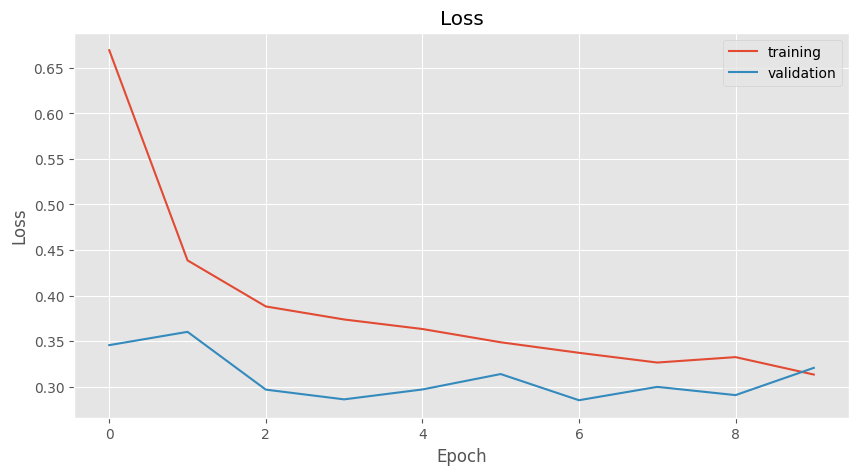

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


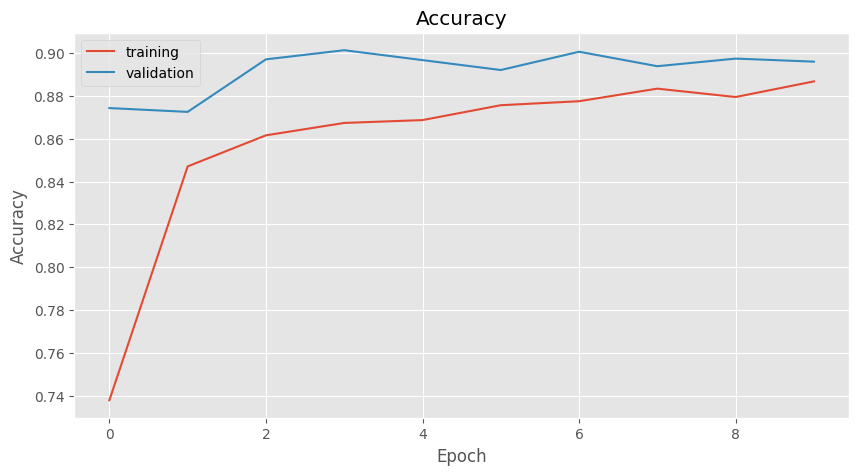

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


## Mengubah Model

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


In [ ]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


10735332